# YouTube Analysis and Recommender System

In this notebook, we perform a detailed analysis of YouTube data to build a recommender system. YouTube, being one of the largest video-sharing platforms, holds a wealth of information that can be leveraged to understand user preferences, predict trends, and suggest relevant content.

## Overview

This project focuses on analyzing YouTube videos, their metadata, user interactions, and building a system that can recommend videos based on different factors such as view history, user preferences, and similar content.

## Objectives

- **Data Collection**: Retrieve YouTube video data, including video titles, descriptions, view counts, likes, and comments.
- **Data Preprocessing**: Clean and prepare the dataset for analysis.
- **Exploratory Data Analysis (EDA)**: Investigate patterns, trends, and insights from the dataset.
- **Recommender System**: Build a content-based or collaborative filtering recommender system to suggest videos to users.
- **Evaluation**: Evaluate the recommender system using appropriate metrics like accuracy, precision, and recall.

## Dataset

The dataset used in this analysis is collected from publicly available YouTube video statistics. It includes various features such as:

- Video Title
- Channel Name
- View Count
- Like Count
- Comment Count
- Video Description
- Tags
- Published Date

## Methodology

We will employ machine learning algorithms to build our recommender system. Depending on the approach, we might use:
- **Content-Based Filtering**: Recommending videos based on similarities between the content of videos.
- **Collaborative Filtering**: Recommending videos based on user interaction history and preferences.

The model will be evaluated based on the ability to suggest relevant and engaging videos to users.

## Conclusion

By the end of this notebook, we aim to have a fully functional recommender system capable of providing personalized video recommendations, enhancing user engagement, and improving their overall experience on YouTube.



## Initializing PySpark

Before using PySpark, we need to initialize the Spark session.

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import random

random.seed(123)

## Load the Data from a CSV file

In [2]:
filePath = os.path.join(os.getcwd(), "dataset", "trending_yt_videos_113_countries.csv")
data = pd.read_csv(filePath, sep=',')
data.head(5)

,title,channel_name,daily_rank,daily_movement,weekly_movement,snapshot_date,country,view_count,like_count,comment_count,description,thumbnail_url,video_id,channel_id,video_tags,kind,publish_date,langauge
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,1,0,49,2025-02-20,ZW,640294,33578,6942,Our first single for 2025\nNot a part of the N...,https://i.ytimg.com/vi/hQGU7Hjr6KA/mqdefault.jpg,hQGU7Hjr6KA,UCPpVYvHuQSIkQwW1pJhfPrA,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN
1,Winky D - Siya,winkyonline,2,0,-1,2025-02-20,ZW,1483949,59662,10408,You can purchase the EP from stores below:\nSP...,https://i.ytimg.com/vi/Mq0J2Q4I71U/mqdefault.jpg,Mq0J2Q4I71U,UC9iqkdRHEbX7hwEu9D6J8wg,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
2,Winky D Fake Love (Official Ai Video),winkyonline,3,0,-1,2025-02-20,ZW,1031541,48158,6185,You can purchase the EP from stores below:\nSP...,https://i.ytimg.com/vi/6YvoX8x6aCw/mqdefault.jpg,6YvoX8x6aCw,UC9iqkdRHEbX7hwEu9D6J8wg,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,4,0,-1,2025-02-20,ZW,75930862,2735285,161203,Watch hip-hop’s MVP put on an epic performance...,https://i.ytimg.com/vi/KDorKy-13ak/mqdefault.jpg,KDorKy-13ak,UCDVYQ4Zhbm3S2dlz7P1GBDg,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,5,45,45,2025-02-20,ZW,4166631,64473,3630,Manchester City were knocked out this season’s...,https://i.ytimg.com/vi/zpieZkvFnlE/mqdefault.jpg,zpieZkvFnlE,UCkzCjdRMrW2vXLx8mvPVLdQ,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB


# YouTube Dataset: Explicit vs. Implicit Data

Explicit data refers to information that is directly provided by the user, platform, or content creators,
whereas implicit data refers to information that is generated based on user interaction, platform algorithms, or system tracking.
In our dataset, we have a combination of both types of data, separated as follows:

## Explicit Data

- **title**: The title of the video, explicitly set by the uploader.
- **channel_name**: The name of the YouTube channel that uploaded the video.
- **description**: The text description provided by the video uploader.
- **thumbnail_url**: The URL of the thumbnail, explicitly assigned or auto-generated by YouTube.
- **video_id**: A unique identifier for the video, assigned by YouTube.
- **channel_id**: A unique identifier for the channel, assigned by YouTube.
- **video_tags**: Tags provided by the content creator for categorization and search optimization.
- **kind**: Indicates the type of content (e.g., YouTube video).
- **publish_date**: The date when the video was published, explicitly recorded by YouTube.
- **language** (or "langauge" as it appears in your dataset): The language setting for the video, either set by the uploader or inferred by YouTube.

## Implicit Data

- **daily_rank**: The ranking of the video for a given day, derived from engagement metrics.
- **daily_movement**: The change in ranking from the previous day, inferred from user engagement trends.
- **weekly_movement**: The ranking shift over a week, based on aggregated engagement data.
- **snapshot_date**: The date when the data was collected, recorded by the system.
- **country**: The country where the video is trending or where the snapshot was taken, inferred from viewer location data.
- **view_count**: The number of views the video has received, recorded and updated by YouTube.
- **like_count**: The number of likes, tracked as users interact with the content.
- **comment_count**: The number of comments, generated from user interactions.


## Filtering columns

As a starter to our project, we decided to cut some of the variables that are less likely to be userful in user recommendation. If needed, we will reload some of the columns needed.

In [3]:
columns_useful = ['title', 'channel_name', 'view_count', 'like_count', 'comment_count', 
                  'video_tags', 'kind', 'publish_date', 'langauge']

# Filter the columns that exist in the dataframe
columns_validas = [c for c in columns_useful if c in data.columns]

# Select only the valid columns
data = data[columns_validas]

# Display the first 5 rows
data.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,640294,33578,6942,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN
1,Winky D - Siya,winkyonline,1483949,59662,10408,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
2,Winky D Fake Love (Official Ai Video),winkyonline,1031541,48158,6185,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,75930862,2735285,161203,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,4166631,64473,3630,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB


## Generating new dimensions

We decided to create a new column called "Engagement Score" that uses a function of weights to generate a number that explains user interaction with the video.

We used a simple formula as shown below: 

$$
\text{Engagement Score} = \frac{\text{like\_count} \times 2 + \text{comment\_count} \times 3}{\text{view\_count} + 1}
$$


We decided to use these weights taking account the level of effort the user needs to put in order to perform these actions, meaning that they are more important the harder it is to do. The +1 on the view count is in order to avoid divisions by zero.

In [4]:
# Creating the engagement score column
data['engagement_score'] = (data['like_count'] * 2 + data['comment_count'] * 3) / (data['view_count'] + 1)

# Sorting by engagement score in descending order
data_sorted = data.sort_values(by='engagement_score', ascending=False)

# Display the first 5 rows
data_sorted.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge,engagement_score
876704,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,456719,11537,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,948049.0
882352,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,455188,11468,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,944780.0
887999,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,453200,11386,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,940558.0
893641,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,450683,11282,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,935212.0
899284,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,447515,11143,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,928459.0


## Normalising the Score

In [5]:
# Calculate min and max values of the engagement_score
min_score = data['engagement_score'].min()
max_score = data['engagement_score'].max()

# Create the scaled engagement score column
data['scaled_engagement_score'] = 1 + 9 * ((data['engagement_score'] - min_score) / (max_score - min_score))

# Select the relevant columns and sort by scaled_engagement_score in descending order
data_sorted = data[['title', 'engagement_score', 'scaled_engagement_score']].sort_values(by='scaled_engagement_score', ascending=False)

# Display the first 5 rows
data_sorted.head(5)



,title,engagement_score,scaled_engagement_score
876704,THE WEEKND - SÃO PAULO LIVESTREAM,948049.0,10.000000
882352,THE WEEKND - SÃO PAULO LIVESTREAM,944780.0,9.968967
887999,THE WEEKND - SÃO PAULO LIVESTREAM,940558.0,9.928887
893641,THE WEEKND - SÃO PAULO LIVESTREAM,935212.0,9.878136
899284,THE WEEKND - SÃO PAULO LIVESTREAM,928459.0,9.814029


## Data Association

We will now dive deeper in our dataset, generating different datasets that provide different information on our data

In [6]:
# Group by 'channel_name' and calculate the average engagement score
channel_engagement = data.groupby('channel_name')['engagement_score'].mean().reset_index()
channel_engagement = channel_engagement.rename(columns={'engagement_score': 'avg_engagement_score'})

# Calculate min and max of avg_engagement_score
min_score_channel = channel_engagement['avg_engagement_score'].min()
max_score_channel = channel_engagement['avg_engagement_score'].max()

# Create the scaled average engagement score column
channel_engagement['scaled_avg_engagement_score'] = 1 + 9 * ((channel_engagement['avg_engagement_score'] - min_score_channel) / (max_score_channel - min_score_channel))

# Sort by avg_engagement_score in descending order
channel_analysis = channel_engagement.sort_values(by='avg_engagement_score', ascending=False)

# Display the top 10 rows
channel_analysis.head(10)


,channel_name,avg_engagement_score,scaled_avg_engagement_score
26687,The Weeknd,267825.547331,10.000000
5557,Coachella,226829.630104,8.622375
10524,GoogleDoodles,165461.954545,6.560178
1674,Alok,23462.932742,1.788448
13857,Kenia Os,18924.956264,1.635954
8695,FORMULA 1,6430.476832,1.216090
9282,Flow Podcast,3586.588321,1.120524
13273,KAROL G,363.453403,1.012213
255,2SekundovyMato,90.802832,1.003051
19466,Nour Chiba نور شيبة,1.296628,1.000044


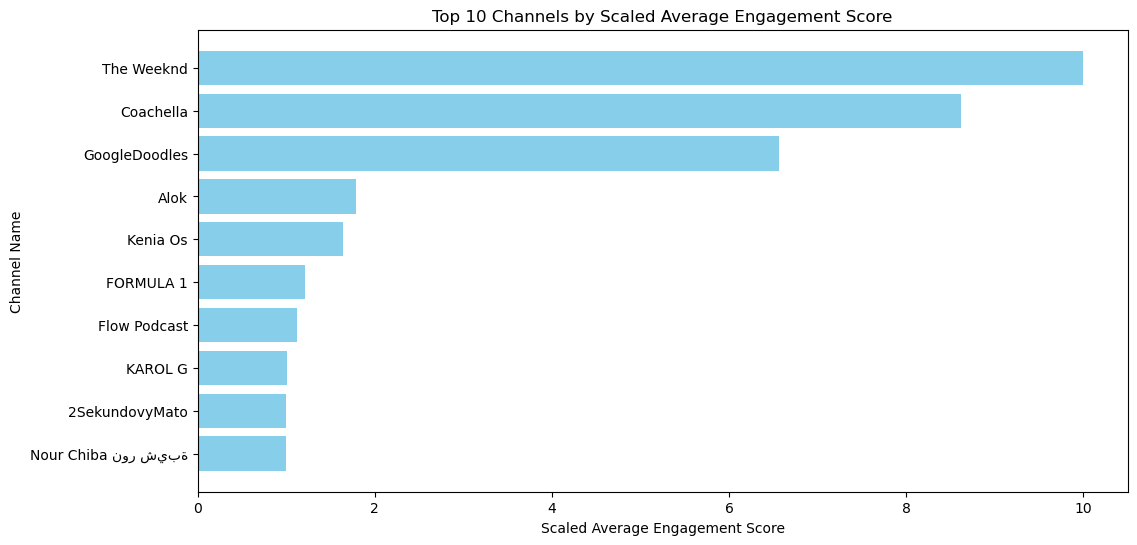

In [7]:
channel_analysis = channel_analysis.sort_values(by="scaled_avg_engagement_score", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(channel_analysis["channel_name"][:10], channel_analysis["scaled_avg_engagement_score"][:10], color='skyblue')
plt.xlabel("Scaled Average Engagement Score")
plt.ylabel("Channel Name")
plt.title("Top 10 Channels by Scaled Average Engagement Score")
plt.gca().invert_yaxis() 
plt.show()

In [8]:
#busca canales similares segun su enagement_score
#cosine : medir qué tan parecidos son dos canales según sus características numéricas, en este caso el scaled_avg_engagement_score.


from sklearn.metrics.pairwise import cosine_similarity

# 1️⃣ Creamos una matriz para calcular similitud
channel_matrix = channel_analysis[["scaled_avg_engagement_score"]].values

# 2️⃣ Similitud coseno entre canales
similarity_matrix = cosine_similarity(channel_matrix)  #we use the similitud of the cosine

# 3️⃣ Creamos un índice para buscar fácilmente por nombre
channel_names = channel_analysis["channel_name"].values
channel_index = {name: idx for idx, name in enumerate(channel_names)}

# 4️⃣ Función para recomendar canales similares
def recommend_similar_channels(channel_name, top_n=5):
    if channel_name not in channel_index:
        print(f"❌ Canal '{channel_name}' no encontrado.")
        return []

    idx = channel_index[channel_name]
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Ordenamos por similitud (excepto el mismo canal)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_similar = sim_scores[1:top_n+1]  # omitimos el primero (es él mismo)

    print(f"📺 Canales similares a '{channel_name}':")
    for i, score in top_similar:
        print(f"  - {channel_names[i]} (Similitud: {score:.3f})")

    return [channel_names[i] for i, _ in top_similar]

# 🔍 Ejemplo: buscar similares a "The Weeknd"
recommend_similar_channels("The Weeknd", top_n=5)


📺 Canales similares a 'The Weeknd':
  - Coachella (Similitud: 1.000)
  - GoogleDoodles (Similitud: 1.000)
  - Alok (Similitud: 1.000)
  - Kenia Os (Similitud: 1.000)
  - FORMULA 1 (Similitud: 1.000)


['Coachella', 'GoogleDoodles', 'Alok', 'Kenia Os', 'FORMULA 1']

## Lets try to find similarities between videos

In [9]:
data.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge,engagement_score,scaled_engagement_score
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,640294,33578,6942,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN,0.137409,1.000001
1,Winky D - Siya,winkyonline,1483949,59662,10408,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN,0.101451,1.000001
2,Winky D Fake Love (Official Ai Video),winkyonline,1031541,48158,6185,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN,0.111359,1.000001
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,75930862,2735285,161203,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en,0.078416,1.000001
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,4166631,64473,3630,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB,0.033561,1.000000


# Sentiment Analysis

Now we will focus on analysing and filtering important data on the tags and title columns. With this method, we will be able to identify key words to generate relationships

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/adriana/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nlt

True

In [14]:
data["video_tags"] = data["video_tags"].astype(str).str.lower()

data["tokens"] = data["video_tags"].apply(word_tokenize)

stop_words = set(stopwords.words("english"))
data["filtered_tokens"] = data["tokens"].apply(lambda words: [w for w in words if w not in stop_words])

# Convert tokens back into a string for sentiment analysis
data["clean_text"] = data["filtered_tokens"].apply(lambda words: " ".join(words))

# Apply Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
data["sentiment_score"] = data["clean_text"].apply(lambda text: sia.polarity_scores(text)["compound"])

# Categorize sentiment based on score
data["sentiment"] = data["sentiment_score"].apply(lambda score: 
    "positive" if score > 0.05 else ("negative" if score < -0.05 else "neutral"))

# Show the results
data[["title", "video_tags", "clean_text", "sentiment_score", "sentiment"]].head()

,title,video_tags,clean_text,sentiment_score,sentiment
0,Jah Prayzah - Mandionei (Official Performance ...,nan,nan,0.0000,neutral
1,Winky D - Siya,nan,nan,0.0000,neutral
2,Winky D Fake Love (Official Ai Video),nan,nan,0.0000,neutral
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,"nfl, football, american football, sport, sports","nfl , football , american football , sport , s...",0.0000,neutral
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,"man city, manchester city, mcfc, man city high...","man city , manchester city , mcfc , man city h...",0.7783,positive


In [15]:
#here we try to implement vader
sia = SentimentIntensityAnalyzer()


data["clean_text"] = data["clean_text"].fillna("")


data["sentiment_score"] = data["clean_text"].apply(lambda text: sia.polarity_scores(text)["compound"])


data["sentiment"] = data["sentiment_score"].apply(lambda score: 
    "positive" if score > 0.05 else ("negative" if score < -0.05 else "neutral"))

data[["title", "video_tags", "clean_text", "sentiment_score", "sentiment"]].head()


,title,video_tags,clean_text,sentiment_score,sentiment
0,Jah Prayzah - Mandionei (Official Performance ...,nan,nan,0.0000,neutral
1,Winky D - Siya,nan,nan,0.0000,neutral
2,Winky D Fake Love (Official Ai Video),nan,nan,0.0000,neutral
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,"nfl, football, american football, sport, sports","nfl , football , american football , sport , s...",0.0000,neutral
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,"man city, manchester city, mcfc, man city high...","man city , manchester city , mcfc , man city h...",0.7783,positive


In [16]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False)

data_tf = vectorizer.transform(data["clean_text"])

def sparse_to_dataframe(sparse_matrix, column_prefix="feature"):

    df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
    df.columns = [f"{column_prefix}_{i}" for i in range(df.shape[1])]
    return df

data_tf_df = sparse_to_dataframe(data_tf)

data_tf_df.insert(0, "title", data["title"].values)

data_tf_df.head()

,title,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_4990,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999
0,Jah Prayzah - Mandionei (Official Performance ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Winky D - Siya,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Winky D Fake Love (Official Ai Video),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Clustering


With the ability to find videos based on sentiment results, we can now expand to providing especific inputs, as a "new users", to obtain recommendations

In [17]:
from sklearn.neighbors import NearestNeighbors

def recommend_videos(user_sentiment, num_recommendations=5, sample_size=100):
    # 🔹 Filtrar videos con el sentimiento deseado
    filtered_videos = data[data["sentiment"] == user_sentiment]

    if filtered_videos.empty or len(filtered_videos) < num_recommendations:
        print("No hay suficientes videos con este sentimiento.")
        return []

    # 🔹 Obtener los índices comunes entre videos y features
    filtered_indices = filtered_videos.index.intersection(data_tf_df.index)

    if filtered_indices.empty:
        print("No se encontraron coincidencias con los datos vectorizados.")
        return []

    # 🔹 Seleccionar características (excepto columna 'title')
    features_matrix = data_tf_df.loc[filtered_indices, data_tf_df.columns[1:]]

    if features_matrix.shape[0] < 2:
        print("No hay suficientes datos para recomendar.")
        return []

    # 🔹 Tomar una muestra aleatoria (máx sample_size)
    sampled_indices = np.random.choice(features_matrix.index, min(sample_size, len(features_matrix)), replace=False)
    sampled_features = features_matrix.loc[sampled_indices]

    # 🔹 Fit y buscar vecinos
    nn_model = NearestNeighbors(n_neighbors=num_recommendations + 1, metric="cosine")
    nn_model.fit(sampled_features)

    # 🔹 Elegir uno de los vídeos muestreados para buscar similares
    query_vector = sampled_features.iloc[[0]]  # Puedes cambiar a `.sample(1)` si quieres aleatoriedad

    distances, indices = nn_model.kneighbors(query_vector)
    
    recommended_indices = sampled_features.iloc[indices[0][1:]].index  # Saltamos el primer (él mismo)

    recommended_titles = data.loc[recommended_indices]["title"].tolist()
    return recommended_titles, sampled_features, indices

# Ejecución
recommendations, sampled_features, neighbor_indices = recommend_videos(user_sentiment="positive", num_recommendations=5, sample_size=500)
print("🎬 Videos Recomendados:", recommendations)


🎬 Videos Recomendados: ["WHAT'S IN YOUR EARS 😱 Cool Gadgets for School", 'Wow! 😍 Making mega yummy chocolate and candy! 😋 #shorts', 'Fun Toilet Fidget 😅 #shorts', 'Fun Toilet Fidget 😅 #shorts', 'The Crossbow Cannibal - PhD Student and *Secret* Serial Killer?? | Mystery & Makeup']


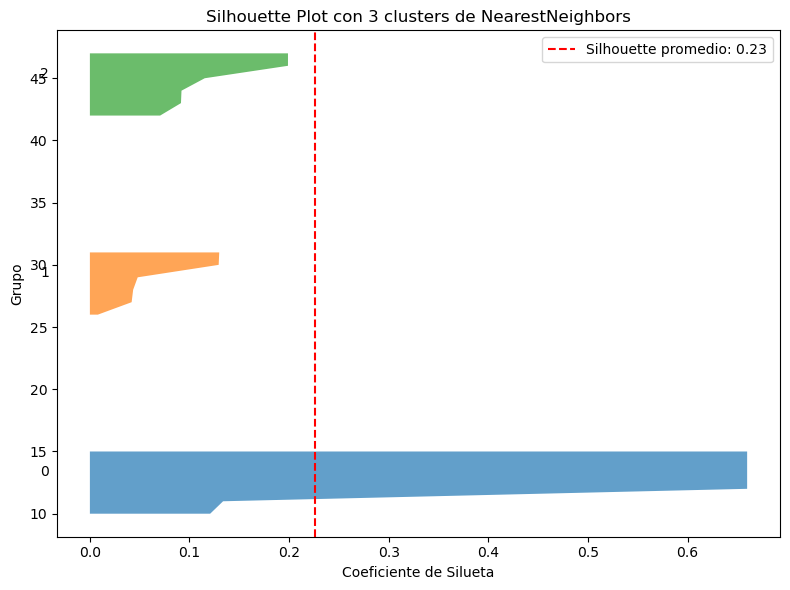

0.2256346459597024

In [18]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

def clustering_with_neighbors(data_tf_df, data, user_sentiment="positive", num_queries=5, num_recommendations=5, sample_size=500):
    filtered_videos = data[data["sentiment"] == user_sentiment]
    filtered_indices = filtered_videos.index.intersection(data_tf_df.index)

    if filtered_indices.empty:
        print("No se encontraron coincidencias.")
        return

    features_matrix = data_tf_df.loc[filtered_indices, data_tf_df.columns[1:]]
    if features_matrix.shape[0] < 2:
        print("Datos insuficientes.")
        return

    # Muestra aleatoria
    sampled_indices = np.random.choice(features_matrix.index, min(sample_size, len(features_matrix)), replace=False)
    sampled_features = features_matrix.loc[sampled_indices]
    
    # Inicializamos
    cluster_labels = np.full(len(sampled_features), -1)
    cluster_id = 0
    
    nn_model = NearestNeighbors(n_neighbors=num_recommendations + 1, metric="cosine")
    nn_model.fit(sampled_features)

    used_indices = set()

    for i in range(num_queries):
        query_idx = np.random.choice(sampled_features.index.difference(used_indices))
        distances, indices = nn_model.kneighbors(sampled_features.loc[[query_idx]])
        group_indices = sampled_features.iloc[indices[0]].index

        for idx in group_indices:
            cluster_labels[sampled_features.index.get_loc(idx)] = cluster_id
            used_indices.add(idx)
        
        cluster_id += 1

    # Filtrar datos válidos
    valid_mask = cluster_labels != -1
    final_features = sampled_features[valid_mask]
    final_labels = cluster_labels[valid_mask]

    # Silhouette Score
    sil_score = silhouette_score(final_features, final_labels)
    sil_values = silhouette_samples(final_features, final_labels)

    # Gráfico
    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10
    for i in np.unique(final_labels):
        ith_values = sil_values[final_labels == i]
        ith_values.sort()
        size = len(ith_values)
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_values, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size, str(i))
        y_lower = y_upper + 10

    ax.axvline(sil_score, color="red", linestyle="--", label=f"Silhouette promedio: {sil_score:.2f}")
    ax.set_title(f"Silhouette Plot con {num_queries} clusters de NearestNeighbors")
    ax.set_xlabel("Coeficiente de Silueta")
    ax.set_ylabel("Grupo")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return sil_score

clustering_with_neighbors(data_tf_df, data, user_sentiment="positive", num_queries=3, num_recommendations=5, sample_size=1000)


We tried using cornac experinment, as in notebook 5.1, but given we do not have any users, data was unconclusive and did not provide useful information. Thus we will carry on with the next steps.

ITEM-BASED METHODS

In [97]:
import cornac
from cornac.models import ItemKNN
from cornac.eval_methods import RatioSplit
from cornac.metrics import RMSE

# 🔹 Seleccionamos los vídeos con mayor engagement
top_items = data.sort_values(by="engagement_score", ascending=False).head(400000)

# 🔹 Preparamos los datos para recomendar canales (canal = item, vídeo = user)
cornac_data = top_items[["title", "channel_name", "engagement_score"]].copy()
cornac_data.rename(columns={
    "channel_name": "user",           # el canal es el usuario
    "title": "item",    # el video es el ítem a recomendar
    "engagement_score": "rating"
}, inplace=True)

# 🔹 Convertimos a lista de tuplas (vídeo, canal, puntuación)
cornac_tuples = cornac_data[["user", "item", "rating"]].values.tolist()

# 🔹 División entrenamiento/test
ratio_split = RatioSplit(data=cornac_tuples, test_size=0.1, seed=42, verbose=True)

# 🔹 Definimos los modelos
K = 50
iknn_cosine = ItemKNN(k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=True)
iknn_pearson = ItemKNN(k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=True)
iknn_pearson_mc = ItemKNN(k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=True)
iknn_adjusted = ItemKNN(k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=True)

# 🔹 Ejecutamos el experimento
cornac.Experiment(
    eval_method=ratio_split,
    models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
    metrics=[RMSE()]
).run()


rating_threshold = 1.0
exclude_unknowns = True


/home/adriana/anaconda3/envs/bigdata/lib/python3.10/site-packages/cornac/data/dataset.py:335: UserWarning: 314551 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/home/adriana/anaconda3/envs/bigdata/lib/python3.10/site-packages/cornac/data/dataset.py:335: UserWarning: 24302 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 12548
Number of items = 45415
Number of ratings = 45449
Max rating = 833836.0
Min rating = 0.2
Global mean = 50.4
---
Test data:
Number of users = 12548
Number of items = 45415
Number of ratings = 13971
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 12548
Total items = 45415

[ItemKNN-Cosine] Training started!


100%|██████████| 45415/45415 [00:01<00:00, 28097.62it/s]



[ItemKNN-Cosine] Evaluation started!


Rating: 100%|██████████| 13971/13971 [00:00<00:00, 17899.20it/s]



[ItemKNN-Pearson] Training started!


100%|██████████| 45415/45415 [00:01<00:00, 32276.88it/s]



[ItemKNN-Pearson] Evaluation started!


Rating: 100%|██████████| 13971/13971 [00:00<00:00, 18884.22it/s]



[ItemKNN-Pearson-MC] Training started!


100%|██████████| 45415/45415 [00:01<00:00, 32961.80it/s]



[ItemKNN-Pearson-MC] Evaluation started!


Rating: 100%|██████████| 13971/13971 [00:00<00:00, 19122.06it/s]



[ItemKNN-AdjustedCosine] Training started!


100%|██████████| 45415/45415 [00:01<00:00, 33445.12it/s]



[ItemKNN-AdjustedCosine] Evaluation started!


Rating: 100%|██████████| 13971/13971 [00:00<00:00, 19674.19it/s]



TEST:
...
                       |    RMSE | Train (s) | Test (s)
---------------------- + ------- + --------- + --------
ItemKNN-Cosine         | 94.9997 |    7.8774 |   1.0123
ItemKNN-Pearson        | 94.9997 |    7.7080 |   0.9154
ItemKNN-Pearson-MC     | 94.9997 |   11.2957 |   0.8878
ItemKNN-AdjustedCosine | 62.1028 |    7.5763 |   0.8829



In [102]:
# 🔁 Obtener los vídeos (items) del modelo
videos_entrenados = list(iknn_pearson.train_set.item_ids)

# 🔁 Obtener los canales asociados a esos vídeos
canales_entrenados = data[data["title"].isin(videos_entrenados)]["channel_name"].dropna().unique()

# 📋 Mostrar los primeros canales encontrados
print("\n📺 Canales presentes en el modelo de recomendación (basado en los vídeos entrenados):")
for canal in canales_entrenados[:20]:  # puedes cambiar el número
    print("-", canal)

# 🔢 Total de canales únicos
print(f"\n🔢 Total de canales únicos en el modelo: {len(canales_entrenados)}")




📺 Canales presentes en el modelo de recomendación (basado en los vídeos entrenados):
- Jah Prayzah
- winkyonline
- NFL
- Comic Elder
- ChrisBrownVEVO
- Zimcelebs Tv
- Nigel Tha Slick Pastor
- AJR
- We Love Animals
- Full Squad Gaming
-  Ossy Marwah I اوسي مروة
- Asoo اسو
- Sherin Amara
- MUZO
- Mohamed Ramadan I محمد رمضان
- حوارات - 7warat
- VIRUS
- LLE عبدالاله
- xBear | ابو عابد الشمري
- Ahmad Aburob 

🔢 Total de canales únicos en el modelo: 12571


In [107]:
# Canal del cual queremos obtener recomendaciones
canal_elegido = "NFL"  # Puedes cambiarlo por otro channel_name

# Verificamos que el canal esté en el conjunto de entrenamiento
if canal_elegido not in iknn_pearson_mc.train_set.uid_map:
    print(f"El canal '{canal_elegido}' no está en los datos de entrenamiento.")
else:
    UIDX = iknn_pearson_mc.train_set.uid_map[canal_elegido]
    TOPK = 10

    # Usamos la función rank de Cornac para obtener recomendaciones
    recomendaciones, puntuaciones = iknn_pearson_mc.rank(UIDX)

    print(f"\n📺 TOP {TOPK} VIDEOS RECOMENDADOS para el canal '{canal_elegido}':")
    mostrados = set()
    i = 0
    for item_idx in recomendaciones:
        # Obtenemos el canal al que pertenece ese video recomendado
        video = iknn_pearson_mc.train_set.item_ids[item_idx]
        canal_recomendado = data[data["title"] == video]["channel_name"].values[0]

        # Evitamos recomendar el mismo canal y duplicados
        if canal_recomendado != canal_elegido and canal_recomendado not in mostrados:
            print(f"{i+1}. {canal_recomendado} — (video: '{video}') — score: {puntuaciones[item_idx]:.2f}")
            mostrados.add(canal_recomendado)
            i += 1
            if i == TOPK:
                break



📺 TOP 10 VIDEOS RECOMENDADOS para el canal 'NFL':
1. JONAS — (video: 'Das große Problem mit Katzen.. | DIE REALITÄT') — score: 0.23
2. Trixie Mattel — (video: 'Trixie's Back! Let's Catch Her Up On the Internet') — score: 0.23
3. Bart Kubicki — (video: 'EKSTREMALNA WSPINACZKA W WIELKIM KANIONIE!') — score: 0.23
4. ФОРСАЖ — (video: 'Дальнейшая судьба Феррари после ПОГОНИ!') — score: 0.23
5. benja calero — (video: 'Si la gente no puede mentir') — score: 0.23
6. Wydad Athletic Club — (video: 'Inside today's training session | 26/08/2024 📹 | Wellness Center') — score: 0.23
7. StudioMoonTV — (video: 'SirYakari na mňa podal TRESTNÉ OZNÁMENIE...') — score: 0.23
8. RAMUNE ラムネ — (video: 'พี่แป้ง @zbingz ปะทะ 'นมอัดเม็ดรสทุเรียน' 🤢🤮 #ramune #รามูเนะ #zbingz #พี่แป้ง #โบ๊ะบ๊ะShorts') — score: 0.23
9. Trần Thị Thu Trang — (video: 'His crush also likes him 😳 #chang0000 #c4class #chany') — score: 0.23
10. Navaami Music  — (video: 'LOFI LOVEE - Sourav Joshi Vlogs | Priya Dhapa | Bharti | Haarsh | Ved

In [108]:
# Elegimos el canal para el que quieres recomendaciones
TOPK = 10

# Verificamos si el canal está en el modelo entrenado
if canal_elegido not in iknn_pearson_mc.train_set.uid_map:
    print(f"❌ El canal '{canal_elegido}' no está presente en el conjunto de entrenamiento.")
else:
    # Obtener el índice interno del canal
    UIDX = iknn_pearson_mc.train_set.uid_map[canal_elegido]

    # Obtener recomendaciones y puntuaciones
    recommendations, scores = iknn_pearson_mc.rank(UIDX)

    print(f"\n🎯 TOP {TOPK} RECOMENDACIONES para el canal '{canal_elegido}':")
    for i in range(TOPK):
        item_id = recommendations[i]
        title = iknn_pearson_mc.train_set.item_ids[item_id]
        score = scores[item_id]
        print(f"{i+1}. {title} (score: {score:.2f})")



🎯 TOP 10 RECOMENDACIONES para el canal 'NFL':
1. Das große Problem mit Katzen.. | DIE REALITÄT (score: 0.23)
2. Trixie's Back! Let's Catch Her Up On the Internet (score: 0.23)
3. EKSTREMALNA WSPINACZKA W WIELKIM KANIONIE! (score: 0.23)
4. Дальнейшая судьба Феррари после ПОГОНИ! (score: 0.23)
5. Si la gente no puede mentir (score: 0.23)
6. Inside today's training session | 26/08/2024 📹 | Wellness Center (score: 0.23)
7. SirYakari na mňa podal TRESTNÉ OZNÁMENIE... (score: 0.23)
8. พี่แป้ง @zbingz ปะทะ 'นมอัดเม็ดรสทุเรียน' 🤢🤮 #ramune #รามูเนะ #zbingz #พี่แป้ง #โบ๊ะบ๊ะShorts (score: 0.23)
9. His crush also likes him 😳 #chang0000 #c4class #chany (score: 0.23)
10. LOFI LOVEE - Sourav Joshi Vlogs | Priya Dhapa | Bharti | Haarsh | Ved Sharma | Asees Kaur (score: 0.23)


In [109]:
from collections import defaultdict

TOPK = 10

# Verificar si el canal está en el modelo
if canal_elegido not in iknn_pearson_mc.train_set.uid_map:
    print(f"❌ El canal '{canal_elegido}' no está en el conjunto de entrenamiento.")
else:
    # Obtener índice interno
    UIDX = iknn_pearson_mc.train_set.uid_map[canal_elegido]

    # Matrices de puntuaciones y similitudes
    rating_mat = iknn_pearson_mc.train_set.matrix
    score_arr = iknn_pearson_mc.ui_mat[UIDX].A.ravel()
    rated_items = np.nonzero(rating_mat[UIDX])[1]  # vídeos que ya ha "visto" ese canal

    # Estructura para guardar resultados
    df = defaultdict(list)

    # Para cada ítem recomendado
    for rec in recommendations[:TOPK]:
        sim_arr = iknn_pearson_mc.sim_mat[rec].A.ravel()
        nearest_neighbor = rated_items[np.argsort(sim_arr[rated_items])[-1]]
        sim = sim_arr[nearest_neighbor]
        score = score_arr[nearest_neighbor]

        # Obtener nombres reales
        item_name = iknn_pearson_mc.train_set.item_ids[rec]
        nn_name = iknn_pearson_mc.train_set.item_ids[nearest_neighbor]

        # Guardar en el diccionario
        df["Recommendation"].append(item_name)
        df["Item NN"].append(nn_name)
        df["Similarity"].append(sim)
        df["Score of the NN"].append(score)
        df["Contribution"].append((score * sim) / np.abs(sim))

    # Crear y mostrar el DataFrame
    rec_df = pd.DataFrame.from_dict(df)
    display(rec_df)


/tmp/ipykernel_650/3350346014.py:36: RuntimeWarning: invalid value encountered in double_scalars
  df["Contribution"].append((score * sim) / np.abs(sim))


,Recommendation,Item NN,Similarity,Score of the NN,Contribution
0,Das große Problem mit Katzen.. | DIE REALITÄT,Anitta's FULL Halftime Show,0.0,0.067123,NaN
1,Trixie's Back! Let's Catch Her Up On the Internet,Anitta's FULL Halftime Show,0.0,0.067123,NaN
2,EKSTREMALNA WSPINACZKA W WIELKIM KANIONIE!,Anitta's FULL Halftime Show,0.0,0.067123,NaN
3,Дальнейшая судьба Феррари после ПОГОНИ!,Anitta's FULL Halftime Show,0.0,0.067123,NaN
4,Si la gente no puede mentir,Anitta's FULL Halftime Show,0.0,0.067123,NaN
5,Inside today's training session | 26/08/2024 📹...,Anitta's FULL Halftime Show,0.0,0.067123,NaN
6,SirYakari na mňa podal TRESTNÉ OZNÁMENIE...,Anitta's FULL Halftime Show,0.0,0.067123,NaN
7,พี่แป้ง @zbingz ปะทะ 'นมอัดเม็ดรสทุเรียน' 🤢🤮 #...,Anitta's FULL Halftime Show,0.0,0.067123,NaN
8,His crush also likes him 😳 #chang0000 #c4class...,Anitta's FULL Halftime Show,0.0,0.067123,NaN
9,LOFI LOVEE - Sourav Joshi Vlogs | Priya Dhapa ...,Anitta's FULL Halftime Show,0.0,0.067123,NaN


In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paso 1: contar cuántos vídeos tiene cada canal (cuántas veces aparece cada ítem)
item_rate_count = cornac_data['item'].value_counts()  # "item" = canal

# Paso 2: hacer los dos gráficos
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Gráfico de cola larga
axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(
    title="long tail of rating frequency",
    xlabel="channels ordered by decreasing frequency",
    ylabel="#videos (ratings)"
)

# Gráfico log-log
count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(
    title="log-log plot",
    xlabel="#videos (log scale)",
    ylabel="#channels (log scale)"
)

plt.tight_layout()
plt.show()
